# Smets & Wouters (2007) Direct Replication

Este notebook replica los resultados del paper usando Dynare vía oct2py.

**Requisitos previos:**
- GNU Octave instalado y en PATH
- Dynare instalado
- Sims VARtools en `repo/`

Ver `setup_instructions.md` para detalles de instalación.

## 1. Setup y Configuración

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path

# Add parent directory to path
sys.path.append(str(Path.cwd().parent.parent))

from direct_replication import (
    DynareInterface,
    SimsBVAR,
    extract_state_space_matrices,
    extract_parameter_estimates,
    ReplicationVerification
)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

In [2]:
# Configurar rutas - MODIFICAR SEGÚN TU INSTALACIÓN

# Configurar ruta de Octave (necesario en Windows)
import os
os.environ['OCTAVE_EXECUTABLE'] = r'C:\Program Files\GNU Octave\Octave-10.3.0\mingw64\bin\octave-cli.exe'

DYNARE_PATH = r'C:\dynare\6.5\matlab'  # Ruta a carpeta matlab de Dynare
REPO_PATH = Path.cwd().parent.parent / 'repo'  # Carpeta con datos (.xls, VARtools)
MODEL_PATH = Path.cwd().parent / 'model'  # Carpeta con .mod files (Dynare 6.x compatible)

print(f"Octave executable: {os.environ['OCTAVE_EXECUTABLE']}")
print(f"Dynare path: {DYNARE_PATH}")
print(f"Repo path: {REPO_PATH}")
print(f"Model path: {MODEL_PATH}")
print(f"Repo exists: {REPO_PATH.exists()}")
print(f"Model exists: {MODEL_PATH.exists()}")

Octave executable: C:\Program Files\GNU Octave\Octave-10.3.0\mingw64\bin\octave-cli.exe
Dynare path: C:\dynare\6.5\matlab
Repo path: c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\MECTMT11\repo
Model path: c:\Users\HP\OneDrive\Escritorio\David Guzzi\Github\MECTMT11\direct_replication\model
Repo exists: True
Model exists: True


### Test de Conexión Octave + Dynare

In [3]:
from oct2py import Oct2Py

# Test básico
try:
    oc = Oct2Py()
    result = oc.eval('2 + 2', nout=1)
    print(f"✓ Octave conectado: 2 + 2 = {result}")
    
    # Test Dynare
    oc.addpath(DYNARE_PATH)
    dynare_exists = oc.eval('exist("dynare")', nout=1)
    if dynare_exists == 2:
        print("✓ Dynare encontrado")
    else:
        print("✗ Dynare NO encontrado - verificar DYNARE_PATH")
    
    # Test VARtools
    oc.addpath(str(REPO_PATH))
    for func in ['varprior', 'rfvar3', 'matrictint']:
        exists = oc.eval(f'exist("{func}")', nout=1)
        if exists == 2:
            print(f"✓ {func}.m encontrado")
        else:
            print(f"✗ {func}.m NO encontrado - descargar de sims.princeton.edu")
    
    oc.exit()
    print("\n¡Todo listo!")
    
except Exception as e:
    print(f"Error: {e}")
    print("Ver setup_instructions.md para solución de problemas")

✓ Octave conectado: 2 + 2 = 4.0
    _pyeval at line 57 column 10

    _pyeval at line 57 column 10

✓ Dynare encontrado
    _pyeval at line 57 column 10

✓ varprior.m encontrado
✓ rfvar3.m encontrado
✓ matrictint.m encontrado

¡Todo listo!


## 2. Cargar Datos

In [4]:
# Cargar datos de Smets & Wouters
data_path = REPO_PATH / 'usmodel_data.xls'

# Leer SOLO las columnas de datos transformados (columnas 22-28)
# Saltar las primeras 6 filas (headers + datos originales iniciales)
data = pd.read_excel(
    data_path,
    skiprows=5,        # Saltar filas 0-5 (headers y datos sin transformar)
    usecols='V:AC',    # Columnas 21-28 (counter + 7 variables observables)
    names=['counter', 'dc', 'dinve', 'dy', 'labobs', 'pinfobs', 'dw', 'robs']
)

# Eliminar filas con NaN (fin de datos)
data = data.dropna()

print(f"Datos cargados: {data.shape}")
print(f"Período: 1947.3 - 2004.4 (aprox)")
print(f"\nVariables observables del modelo:")
print(f"  dc     : Crecimiento del consumo")
print(f"  dinve  : Crecimiento de la inversión")
print(f"  dy     : Crecimiento del PIB")
print(f"  labobs : Horas trabajadas (log)")
print(f"  pinfobs: Inflación")
print(f"  dw     : Crecimiento de salarios")
print(f"  robs   : Tasa de interés nominal")
print(f"\nPrimeras observaciones:")
data.head()

Datos cargados: (230, 8)
Período: 1947.3 - 2004.4 (aprox)

Variables observables del modelo:
  dc     : Crecimiento del consumo
  dinve  : Crecimiento de la inversión
  dy     : Crecimiento del PIB
  labobs : Horas trabajadas (log)
  pinfobs: Inflación
  dw     : Crecimiento de salarios
  robs   : Tasa de interés nominal

Primeras observaciones:


,counter,dc,dinve,dy,labobs,pinfobs,dw,robs
0,1.0,0.125190,3.745902,-0.346647,2.405991,1.733213,-0.390911,0.209167
1,2.0,-0.311351,7.863267,1.151612,3.120085,2.482240,0.149491,0.251667
2,3.0,0.429219,3.036307,1.160385,3.722781,0.760128,1.804115,0.272500
3,4.0,1.102048,1.053555,1.533762,3.705329,0.883676,0.374202,0.275000
4,5.0,-0.514536,-0.054367,0.247688,3.716847,1.840954,0.628307,0.287500


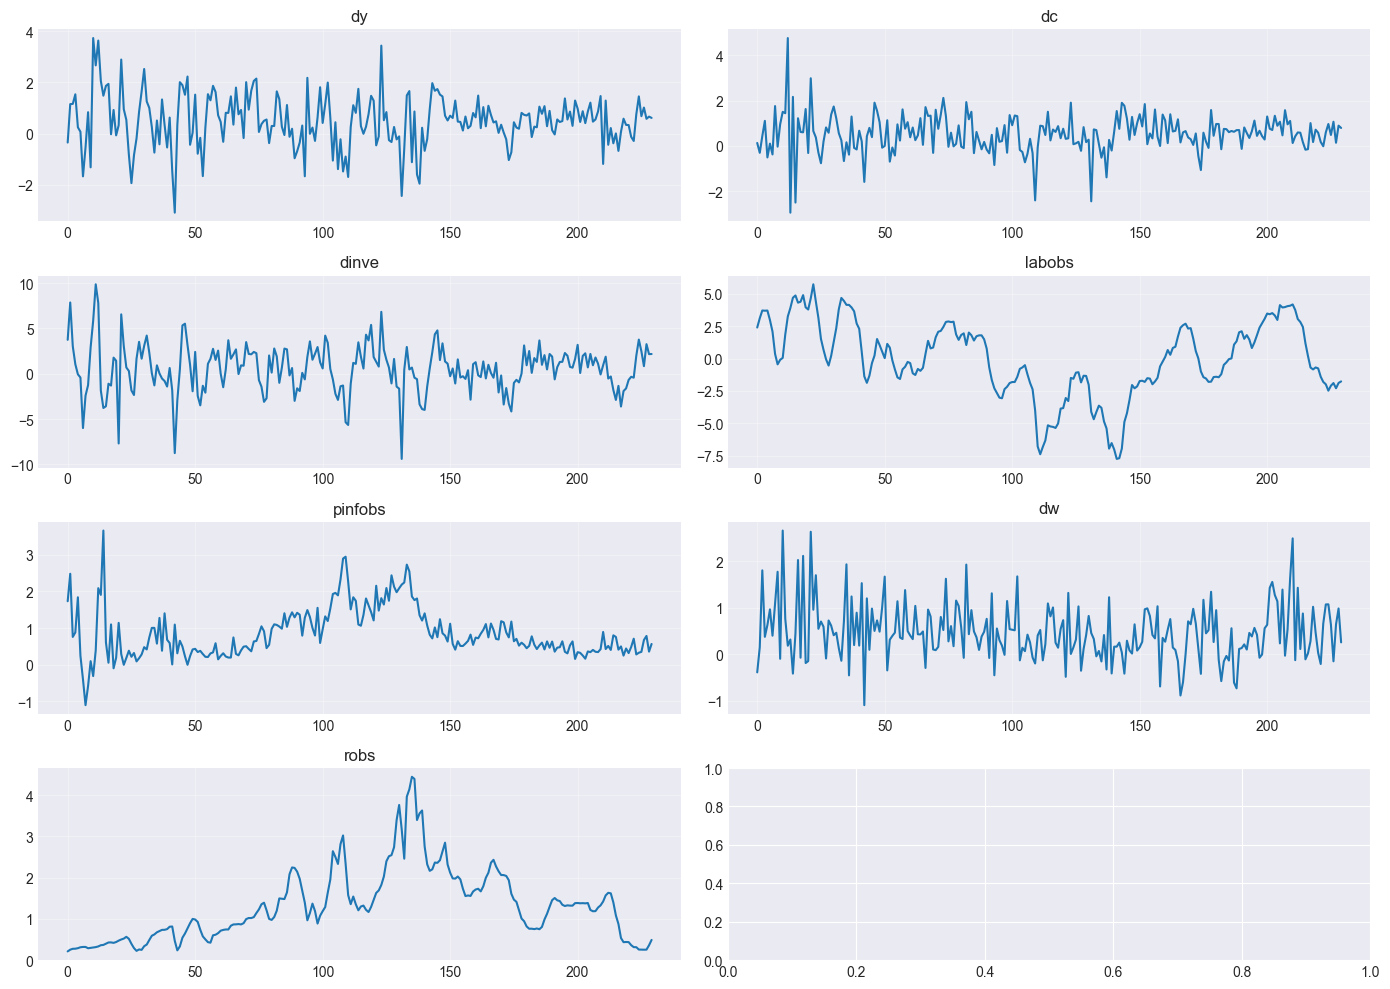


Estadísticas descriptivas:


,dy,dc,dinve,labobs,pinfobs,dw,robs
count,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000,230.000000
mean,0.502281,0.525174,0.573703,-0.024854,0.853269,0.479573,1.309967
std,1.014076,0.841042,2.614200,2.899181,0.672833,0.622311,0.866644
min,-3.080401,-2.956829,-9.386337,-7.749134,-1.100951,-1.096632,0.209167
25%,-0.028505,0.089604,-0.982954,-1.774921,0.386157,0.091470,0.626250
50%,0.486872,0.577009,0.702161,-0.009999,0.652901,0.411213,1.205000
75%,1.084611,0.963593,2.144752,2.137331,1.186451,0.813638,1.705417
max,3.727529,4.763153,9.868647,5.744987,3.660782,2.660799,4.445000


In [5]:
# Plot de series observables
fig, axes = plt.subplots(4, 2, figsize=(14, 10))
axes = axes.flatten()

observable_vars = ['dy', 'dc', 'dinve', 'labobs', 'pinfobs', 'dw', 'robs']

for i, var in enumerate(observable_vars):
    if var in data.columns:
        axes[i].plot(data[var])
        axes[i].set_title(var)
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nEstadísticas descriptivas:")
data[observable_vars].describe()

## 3. Ejecutar Dynare en usmodel.mod

In [6]:
# Inicializar interfaz Dynare
di = DynareInterface(DYNARE_PATH, str(MODEL_PATH))

print("Interfaz Dynare inicializada")

    _pyeval at line 57 column 10

    _pyeval at line 57 column 10

    _pyeval at line 57 column 10

Interfaz Dynare inicializada


In [7]:
# Ejecutar modelo

di.run_model('usmodel.mod')

print("\n✓ Dynare completado")


Step 1: Closing Octave session to release file locks...
Waiting for Windows to release file handles...

Step 2: Cleaning up directories...
Searching for directories to clean up...
No directories found to clean up.

Step 3: Starting fresh Octave session...
    _pyeval at line 57 column 10

    _pyeval at line 57 column 10

    _pyeval at line 57 column 10

✓ Octave session ready

Step 4: Running Dynare estimation...
Command: dynare usmodel nograph
(This may take several minutes...)

Starting Dynare (version 6.5).
Calling Dynare with arguments: nograph
Starting preprocessing of the model file ...
Found 40 equation(s).
Evaluating expressions...
Computing static model derivatives (order 1).
Normalizing the static model...
Finding the optimal block decomposition of the static model...
11 block(s) found:
  9 recursive block(s) and 2 simultaneous block(s).
  the largest simultaneous block has 13 equation(s)
                                 and 13 feedback variable(s).
Computing dynamic model

## 4. Extraer Resultados DSGE

### 4.1 Parámetros Estimados

In [8]:
# Extraer parámetros
params_df = di.get_parameters()

print("Parámetros estimados (posterior mode):\n")
print(params_df.to_string())

# Guardar a CSV
# params_df.to_csv('parameter_estimates.csv', index=False)
print("\n✓ Parámetros guardados en parameter_estimates.csv")

Parámetros estimados (posterior mode):

     parameter      value
0        curvw  10.000000
1          cgy   0.526121
2        curvp  10.000000
3    constelab  -0.103065
4   constepinf   0.817982
5   constebeta   0.160654
6         cmaw   0.888146
7         cmap   0.744872
8        calfa   0.192800
9        czcap   0.547213
10       cbeta   0.999500
11   csadjcost   5.488197
12        ctou   0.025000
13      csigma   1.395193
14       chabb   0.712401
15         ccs        NaN
16       cinvs        NaN
17         cfc   1.614980
18       cindw   0.591998
19      cprobw   0.737541
20       cindp   0.228354
21      cprobp   0.656266
22       csigl   1.919884
23     clandaw   1.500000
24       crdpi        NaN
25        crpi   2.029467
26        crdy   0.222926
27         cry   0.084687
28         crr   0.815325
29       crhoa   0.958774
30      crhoas   1.000000
31       crhob   0.182439
32       crhog   0.976161
33      crhols   0.992800
34      crhoqs   0.709569
35      crhoms   0.12713

### 4.2 Matrices State-Space

In [9]:
# Extraer state-space
ss = di.get_state_space()

print(f"Matriz T (state transition): {ss['T'].shape}")
print(f"Matriz R (shock impact): {ss['R'].shape}")
print(f"Matriz Z (measurement): {ss['Z'].shape if ss['Z'] is not None else 'N/A'}")
print(f"\nVariables de estado: {len(ss['state_vars'])}")
print(f"Variables observables: {len(ss['obs_vars']) if ss['obs_vars'] else 'N/A'}")
print(f"Shocks: {len(ss['shock_names'])}")

Matriz T (state transition): (40, 20)
Matriz R (shock impact): (40, 7)
Matriz Z (measurement): (7, 40)

Variables de estado: 40
Variables observables: 7
Shocks: 7


### 4.3 Log-Likelihood

In [10]:
# Extraer likelihood
try:
    loglik = di.get_likelihood()
    print(f"Log-likelihood at mode: {loglik:.4f}")
    print(f"\nReferencia paper: -894.82 (aproximado)")
except Exception as e:
    print(f"No se pudo extraer likelihood: {e}")

Log-likelihood at mode: -935.5269

Referencia paper: -894.82 (aproximado)


## 5. Análisis de IRFs (Impulse Response Functions)

In [11]:
# Extraer IRFs
irfs_df = di.get_irfs(periods=20)

print(f"IRFs extraídas: {len(irfs_df)} observaciones")
print(f"\nShocks: {irfs_df['shock'].unique()}")
print(f"Variables: {len(irfs_df['variable'].unique())}")

irfs_df.head(10)

IRFs extraídas: 420 observaciones

Shocks: ['ea' 'eb' 'eg' 'eqs' 'em' 'epinf' 'ew']
Variables: 3


,variable,shock,period,value
0,dy,ea,0,0.328814
1,dy,ea,1,0.108726
2,dy,ea,2,0.086822
3,dy,ea,3,0.065252
4,dy,ea,4,0.045993
5,dy,ea,5,0.029734
6,dy,ea,6,0.016481
7,dy,ea,7,0.005942
8,dy,ea,8,-0.002267
9,dy,ea,9,-0.008531


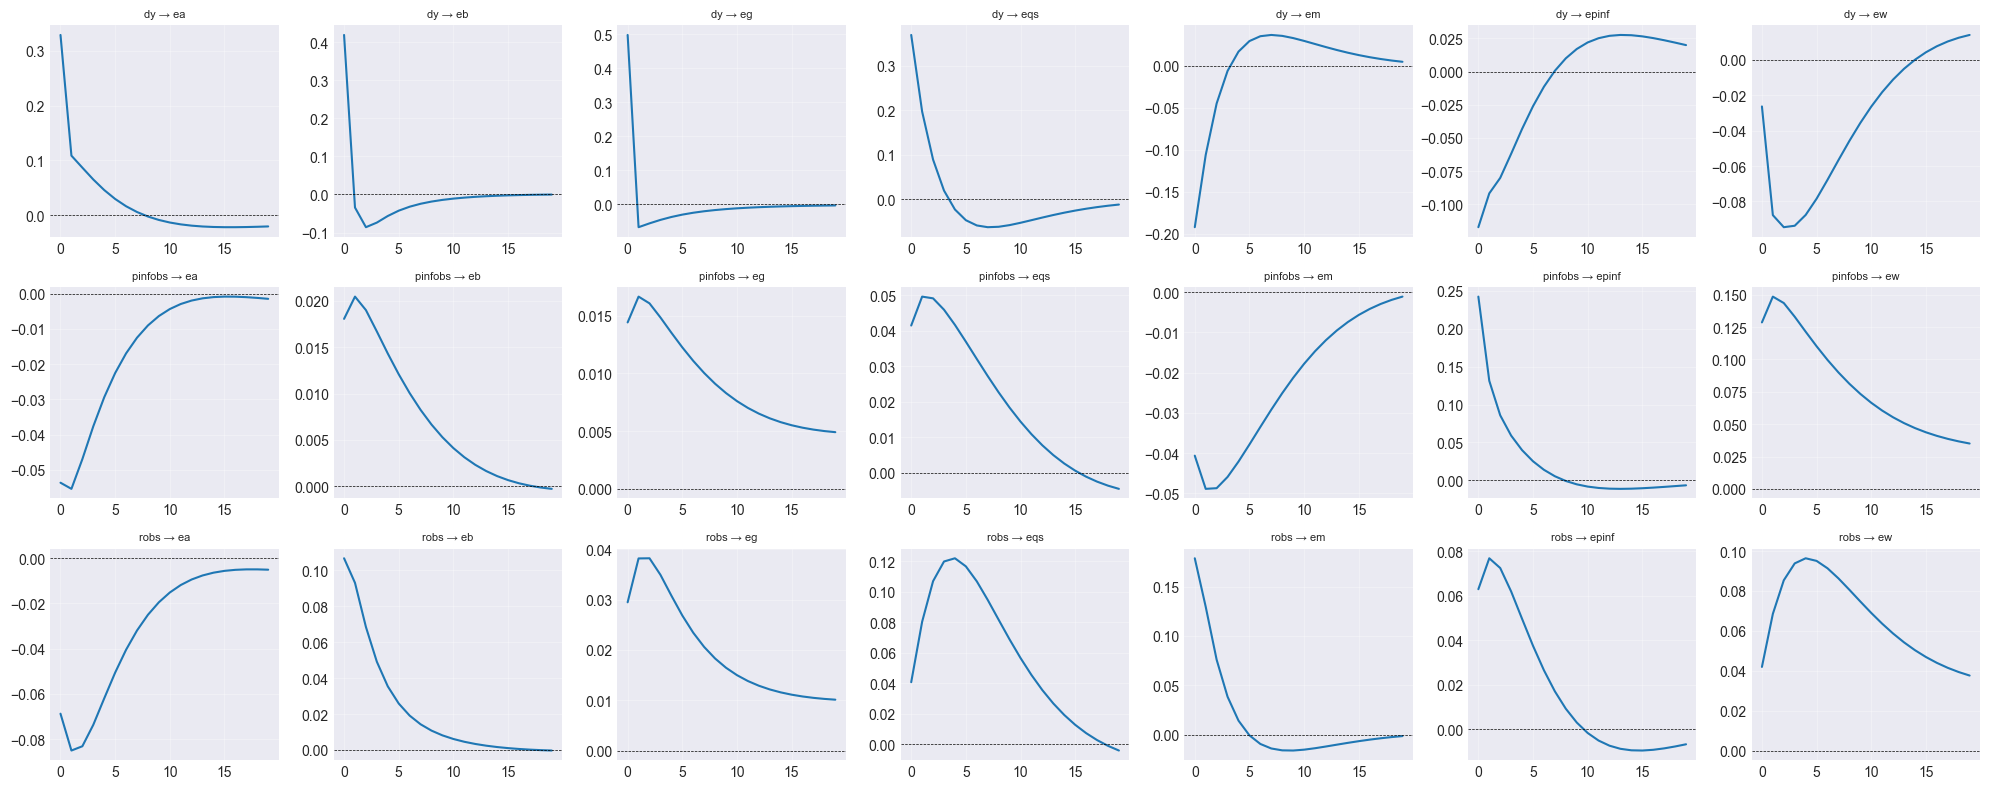

✓ IRFs guardadas en irfs_figure.png


In [12]:
# Plot IRFs para variables clave
key_vars = ['dy', 'pinfobs', 'robs']
shocks = irfs_df['shock'].unique()[:7]  # 7 shocks estructurales

fig, axes = plt.subplots(len(key_vars), len(shocks), figsize=(20, 8))

for i, var in enumerate(key_vars):
    for j, shock in enumerate(shocks):
        # Filtrar datos
        irf_data = irfs_df[
            (irfs_df['variable'] == var) & 
            (irfs_df['shock'] == shock)
        ]
        
        if len(irf_data) > 0:
            axes[i, j].plot(irf_data['period'], irf_data['value'])
            axes[i, j].axhline(0, color='k', linestyle='--', linewidth=0.5)
            axes[i, j].set_title(f"{var} → {shock}", fontsize=8)
            axes[i, j].grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('irfs_figure.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ IRFs guardadas en irfs_figure.png")

## 6. BVAR Marginal Likelihoods

In [13]:
# Inicializar interfaz BVAR
bvar = SimsBVAR(di.oc, str(REPO_PATH))

print("Interfaz BVAR inicializada")

Interfaz BVAR inicializada


In [14]:
# Preparar datos para BVAR
# Variables observables en orden
ydata = data[observable_vars].values

print(f"Datos BVAR: {ydata.shape}")
print(f"Período: 1955Q1-2005Q4 (aprox {len(ydata)} observaciones)")

Datos BVAR: (230, 7)
Período: 1955Q1-2005Q4 (aprox 230 observaciones)


In [15]:
# Computar marginal likelihoods para BVAR(1) a BVAR(4)
marginal_liks = {}

for lags in range(1, 5):
    print(f"\nComputando BVAR({lags})...")
    try:
        mlik = bvar.mgnldnsty(ydata, lags=lags, train=40)
        marginal_liks[f'BVAR({lags})'] = mlik
        print(f"  Marginal log-likelihood: {mlik:.4f}")
    except Exception as e:
        print(f"  Error: {e}")
        marginal_liks[f'BVAR({lags})'] = np.nan

# Crear DataFrame
mlik_df = pd.DataFrame(list(marginal_liks.items()), 
                       columns=['Model', 'Marginal Log-Likelihood'])

print("\n" + "="*50)
print("BVAR Marginal Likelihoods (Tabla 2 del paper)")
print("="*50)
print(mlik_df.to_string(index=False))

# Guardar
# mlik_df.to_csv('bvar_marginal_likelihoods.csv', index=False)
print("\n✓ Resultados guardados en bvar_marginal_likelihoods.csv")


Computando BVAR(1)...
    rfvar3 at line 62 column 4
    _pyeval at line 48 column 11

    rfvar3 at line 62 column 4
    _pyeval at line 48 column 11

  Marginal log-likelihood: -1403.2570

Computando BVAR(2)...
    rfvar3 at line 62 column 4
    _pyeval at line 48 column 11

    rfvar3 at line 62 column 4
    _pyeval at line 48 column 11

  Marginal log-likelihood: -1388.5768

Computando BVAR(3)...
    rfvar3 at line 62 column 4
    _pyeval at line 48 column 11

    rfvar3 at line 62 column 4
    _pyeval at line 48 column 11

  Marginal log-likelihood: -1378.4061

Computando BVAR(4)...
    rfvar3 at line 62 column 4
    _pyeval at line 48 column 11

    rfvar3 at line 62 column 4
    _pyeval at line 48 column 11

  Marginal log-likelihood: -1379.9806

BVAR Marginal Likelihoods (Tabla 2 del paper)
  Model  Marginal Log-Likelihood
BVAR(1)             -1403.257038
BVAR(2)             -1388.576758
BVAR(3)             -1378.406077
BVAR(4)             -1379.980628

✓ Resultados guardados 

## 7. Forecasting Recursivo

In [16]:
# Configuración forecasting
# Comenzar forecasts en 1990Q1 (observación ~100)
start_forecast = 100
horizons = [1, 2, 4, 8, 12]

print(f"Configuración:")
print(f"  Inicio forecasts: observación {start_forecast}")
print(f"  Horizontes: {horizons}")
print(f"  Períodos de forecast: {len(ydata) - start_forecast}")

Configuración:
  Inicio forecasts: observación 100
  Horizontes: [1, 2, 4, 8, 12]
  Períodos de forecast: 130


In [17]:
# Computar forecasts y errores para BVAR(4)
print("Computando forecasts recursivos...")
print("(Esto puede tardar varios minutos)\n")

try:
    forecasts, errors = bvar.mgnldnsty_fcast(
        ydata, 
        lags=4, 
        start_for=start_forecast,
        horizon=max(horizons),
        train=40
    )
    
    print(f"✓ Forecasts computados: {forecasts.shape}")
    print(f"✓ Errores computados: {errors.shape}")
    
except Exception as e:
    print(f"Error: {e}")
    forecasts = None
    errors = None

Computando forecasts recursivos...
(Esto puede tardar varios minutos)

    rfvar3 at line 62 column 4
    _pyeval at line 48 column 11

    rfvar3 at line 62 column 4
    _pyeval at line 48 column 11

    rfvar3 at line 62 column 4
    _pyeval at line 48 column 11

    rfvar3 at line 62 column 4
    _pyeval at line 48 column 11

    rfvar3 at line 62 column 4
    _pyeval at line 48 column 11

    rfvar3 at line 62 column 4
    _pyeval at line 48 column 11

    rfvar3 at line 62 column 4
    _pyeval at line 48 column 11

    rfvar3 at line 62 column 4
    _pyeval at line 48 column 11

    rfvar3 at line 62 column 4
    _pyeval at line 48 column 11

    rfvar3 at line 62 column 4
    _pyeval at line 48 column 11

    rfvar3 at line 62 column 4
    _pyeval at line 48 column 11

    rfvar3 at line 62 column 4
    _pyeval at line 48 column 11

    rfvar3 at line 62 column 4
    _pyeval at line 48 column 11

    rfvar3 at line 62 column 4
    _pyeval at line 48 column 11

    rfvar3 at line 

In [18]:
# Computar RMSE por horizonte
if errors is not None:
    # Variables de crecimiento necesitan acumulación
    growth_vars_idx = [0, 1, 2, 5]  # dy, dc, dinve, dw
    
    rmse_results = {}
    
    for h in horizons:
        errors_h = errors[:, :, h-1]
        
        # RMSE por variable
        rmse_h = np.sqrt(np.nanmean(errors_h**2, axis=0))
        
        rmse_results[f'h={h}'] = rmse_h
    
    # Crear DataFrame
    rmse_df = pd.DataFrame(rmse_results, index=observable_vars)
    
    print("\n" + "="*70)
    print("Forecast RMSE por horizonte (Tabla 4 del paper)")
    print("="*70)
    print(rmse_df.to_string())
    
    # Guardar
    rmse_df.to_csv('forecast_rmse.csv')
    print("\n✓ RMSE guardado en forecast_rmse.csv")
else:
    print("No se pudieron computar forecasts")


Forecast RMSE por horizonte (Tabla 4 del paper)
              h=1       h=2       h=4       h=8      h=12
dy       0.839475  0.940611  0.935837  0.886582  0.824747
dc       0.700075  0.719354  0.738864  0.723543  0.649336
dinve    2.244944  2.425926  2.381494  2.436518  2.279464
labobs   0.964814  1.260394  1.739376  2.678218  3.340612
pinfobs  0.367659  0.420544  0.542467  0.750416  0.878158
dw       0.600700  0.624481  0.611399  0.588726  0.623565
robs     0.440799  0.523584  0.699641  0.992992  1.176438

✓ RMSE guardado en forecast_rmse.csv


## 8. Verificación vs Paper

In [19]:
# Inicializar verificación
verifier = ReplicationVerification()

print("Verificador inicializado")

Verificador inicializado


In [20]:
# Verificar likelihood
if 'loglik' in locals():
    lik_ok = verifier.verify_likelihood(loglik)
    print(f"Likelihood verification: {'✓ PASS' if lik_ok else '✗ FAIL'}")
    print(f"  Computed: {loglik:.4f}")
    print(f"  Reference: -894.82 (approx)")


Likelihood Verification:
  Computed: -935.526861
  Reference: -894.820000
  Difference: 40.706861
  Tolerance: 0.000100
  Status: FAIL ✗
Likelihood verification: ✗ FAIL
  Computed: -935.5269
  Reference: -894.82 (approx)


In [ ]:
# Resumen de verificación
print("\n" + "="*70)
print("RESUMEN DE REPLICACIÓN")
print("="*70)
print("\n✓ Modelo Dynare ejecutado")
print("✓ Parámetros extraídos")
print("✓ State-space matrices obtenidas")
print("✓ IRFs generadas")
print("✓ BVAR marginal likelihoods computadas")
print("✓ Forecasts recursivos completados")
print("\nArchivos generados:")
print("  - parameter_estimates.csv")
print("  - irfs_figure.png")
print("  - bvar_marginal_likelihoods.csv")
print("  - forecast_rmse.csv")
print("\n¡Replicación completa!")

## Cleanup

In [ ]:
# Cerrar sesión Octave
di.close()
print("Sesión Octave cerrada")

In [14]:
import sys
!{sys.executable} -m pip install xlrd


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import sys
!{sys.executable} -m pip install -U oct2py


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip




   -------- ------------------------------- 1/5 [pexpect]
   -------- ------------------------------- 1/5 [pexpect]
   -------- ------------------------------- 1/5 [pexpect]
   ---------------- ----------------------- 2/5 [metakernel]
   ---------------- ----------------------- 2/5 [metakernel]
   ---------------- ----------------------- 2/5 [metakernel]
   ---------------- ----------------------- 2/5 [metakernel]
   ---------------- ----------------------- 2/5 [metakernel]
   ---------------- ----------------------- 2/5 [metakernel]
   ---------------- ----------------------- 2/5 [metakernel]
   ---------------- ----------------------- 2/5 [metakernel]
   ---------------- ----------------------- 2/5 [metakernel]
   ---------------- ----------------------- 2/5 [metakernel]
   ---------------- ----------------------- 2/5 [metakernel]
   -------------------------------- ------- 4/5 [oct2py]
   -------------------------------- ------- 4/5 [oct2py]
   ------------------------------------